In [ ]:
# prompt: colab mount

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This notebook filters RNA-seq samples from TCGA based on sample barcode plate information, resolving duplicate entries per patient.
It ensures one sample per patient is selected using specific barcode rules.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
# Define the base folder path to your project directory in Google Drive
Ds_project_folder_path = '/content/drive/MyDrive/DS_project/'

# Folder where raw input data is stored
raw_data_path = 'Data/1_raw_data/'

# Folder where processed output data will be saved
gene_name_mapping_data_path = 'Data/2_gene_name_mapping_data/'

filtered_by_plate_rna_seq_data_path = 'Data/3_RNA_seq_sample_filtering_by_plate/'

In [ ]:
# Whether to use gene-mapped data (True) or raw probe-based data (False)

gene_mapping = False

In [ ]:
# Function to load GBM and LGG RNA-seq data depending on whether gene mapping is applied


def Data_load(gene_mapping = True):
  if gene_mapping:
    path = Ds_project_folder_path + gene_name_mapping_data_path
    rna_seq_gbm_data = pd.read_csv(path + 'TCGA-GBM_mRNA_gene_mapping.csv', index_col=0).T
    rna_seq_lgg_data = pd.read_csv(path + 'TCGA-LGG_mRNA_gene_mapping.csv', index_col=0).T

  else:
    path = Ds_project_folder_path + raw_data_path
    rna_seq_gbm_data = pd.read_csv(path + 'TCGA-GBM_mRNA.csv', index_col=0).T
    rna_seq_lgg_data = pd.read_csv(path + 'TCGA-LGG_mRNA.csv', index_col=0).T

  return rna_seq_gbm_data, rna_seq_lgg_data

In [ ]:
rna_seq_gbm_data, rna_seq_lgg_data = Data_load(gene_mapping = gene_mapping)

In [ ]:
# Extract the list of sample IDs from the index (GBM)

new_index_gbm =  [sample[:16] for sample in rna_seq_gbm_data.index.to_list()]
new_index_lgg =  [sample[:16] for sample in rna_seq_lgg_data.index.to_list()]

# Build a dictionary: patient ID → list of all samples matching that patient

operlap_gbm = {new_name:[]for new_name in new_index_gbm}
for sample in rna_seq_gbm_data.index.to_list():
  for new_name in new_index_gbm:
    if new_name in sample and sample not in operlap_gbm[new_name]:
      operlap_gbm[new_name].append(sample)

overlap_lgg = {new_name:[]for new_name in new_index_lgg}
for sample in rna_seq_lgg_data.index.to_list():
  for new_name in new_index_lgg:
    if new_name in sample and sample not in overlap_lgg[new_name]:
      overlap_lgg[new_name].append(sample)

#### statistics

In [ ]:
GBM_plate_to_sample = {sample.split('-')[5]: 0 for sample in  rna_seq_gbm_data.index.to_list()}
for sample in  rna_seq_gbm_data.index.to_list():
  GBM_plate_to_sample[sample.split('-')[5]] +=1

LGG_plate_to_sample = {sample.split('-')[5]: 0 for sample in rna_seq_lgg_data.index.to_list()}
for sample in rna_seq_lgg_data.index.to_list():
  LGG_plate_to_sample[sample.split('-')[5]] +=1

In [ ]:
GBM_plate_to_sample

{'A96R': 52,
 '1849': 84,
 'A96U': 36,
 '1850': 72,
 'A96S': 80,
 'A96T': 46,
 '2005': 1,
 '1900': 1}

In [ ]:
overlap_sample = 0
for k, v in operlap_gbm.items():
  if len(v) > 1:
    overlap_sample += len(v)

print('Total # of downloaded sample from GDC : ', len(new_index_gbm))
print('Overlaped # of samples by plate : ', overlap_sample)

Total # of downloaded sample from GDC :  372
Overlaped # of samples by plate :  173


In [ ]:
overlap_sample = 0
for k, v in overlap_lgg.items():
  if len(v) > 1:
    overlap_sample += len(v)

print('Total # of downloaded sample from GDC : ', len(new_index_lgg))
print('Overlaped # of samples by plate : ', overlap_sample)

Total # of downloaded sample from GDC :  516
Overlaped # of samples by plate :  0


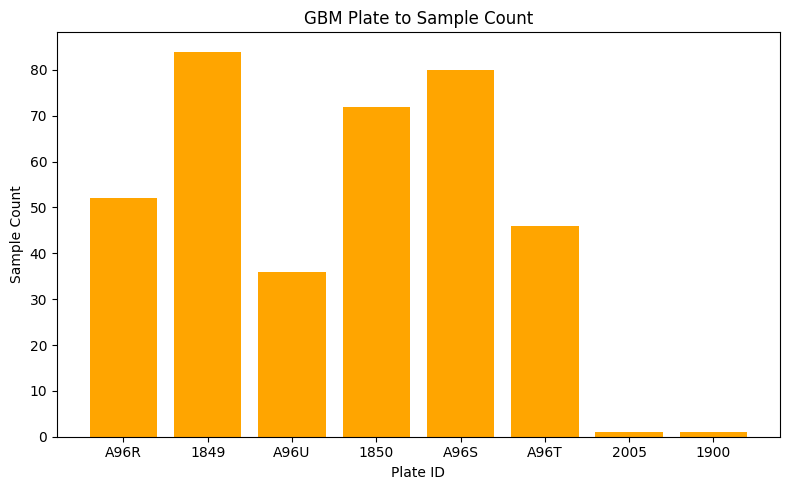

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(GBM_plate_to_sample.keys(), GBM_plate_to_sample.values(), color='orange')
plt.xlabel("Plate ID")
plt.ylabel("Sample Count")
plt.title("GBM Plate to Sample Count")
plt.tight_layout()
plt.show()

Sample selection

In [ ]:
# Reduce duplicate samples to just one per patient using filtering rules
operlap_v2 = {new_name:[]for new_name in new_index_gbm}
for k, v in operlap_gbm.items():
  if len(v) == 1:         # Only one sample: keep it
    operlap_v2[k] = v[0]
  else:
    filter_1 = [] # check 01R, RNA seq order
    for rna_seq in v:
      if '01R' in rna_seq:
        filter_1.append(rna_seq)
    if len(filter_1) == 1:
      operlap_v2[k] = filter_1[0]
    else:
      filter_2 = [] # check 1849 in plate ID
      for rna_seq in v:
        if '1849' in rna_seq:
          filter_2.append(rna_seq)
      if len(filter_2) == 1:
        operlap_v2[k] = filter_2[0]
      else:
        filter_3 = [] # check A96U or A96S in plate ID
        for rna_seq in v:
          if 'A96' in rna_seq:
            filter_3.append(rna_seq)
        if len(filter_3) == 1:
          operlap_v2[k] = filter_3[0]

In [ ]:
GBM_plate_to_sample_v2 = {sample.split('-')[5]: 0 for sample in operlap_v2.values()}
for sample in operlap_v2.values():
  GBM_plate_to_sample_v2[sample.split('-')[5]] +=1

In [ ]:
GBM_plate_to_sample_v2

{'A96R': 30, '1849': 81, 'A96U': 35, '1850': 64, 'A96T': 33, 'A96S': 42}

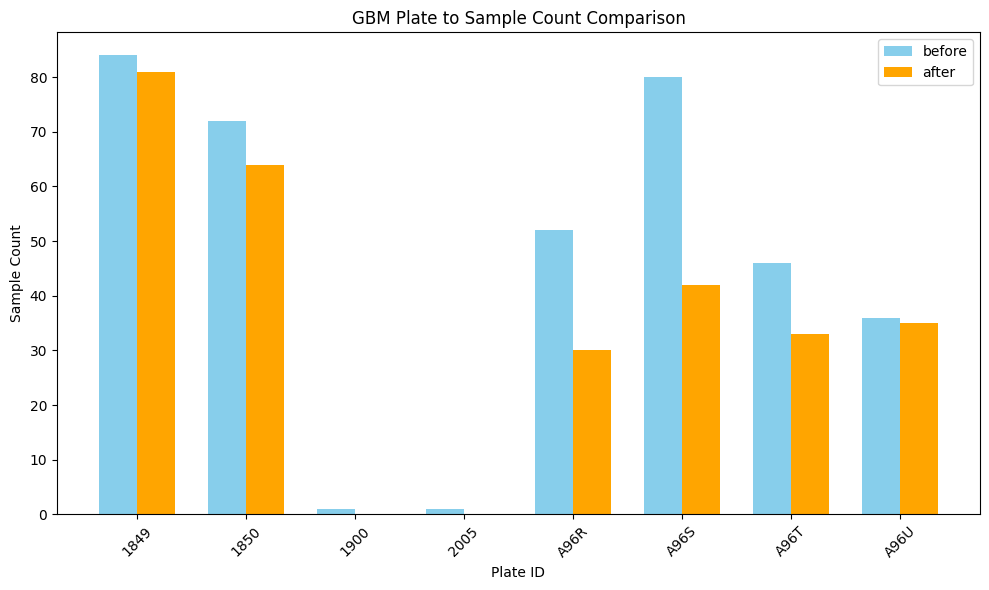

In [ ]:
all_keys = sorted(set(GBM_plate_to_sample) | set(GBM_plate_to_sample_v2))

v1_values = [GBM_plate_to_sample.get(k, 0) for k in all_keys]
v2_values = [GBM_plate_to_sample_v2.get(k, 0) for k in all_keys]

x = range(len(all_keys))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], v1_values, width=bar_width, label='before', color='skyblue')
plt.bar([i + bar_width/2 for i in x], v2_values, width=bar_width, label='after', color='orange')

plt.xticks(x, all_keys, rotation=45)
plt.xlabel("Plate ID")
plt.ylabel("Sample Count")
plt.title("GBM Plate to Sample Count Comparison")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
rna_seq_gbm_data = rna_seq_gbm_data.loc[operlap_v2.values()]

In [ ]:
new_gbm_name = {v: k for k, v in operlap_v2.items()}
new_lgg_name = {sample:sample[:16] for sample in new_index_lgg}

rna_seq_gbm_data = rna_seq_gbm_data.rename(index=new_gbm_name)
rna_seq_lgg_data = rna_seq_lgg_data.rename(index=new_lgg_name)

rna_seq_gbm_data = rna_seq_gbm_data.T
rna_seq_lgg_data = rna_seq_lgg_data.T

In [ ]:
# prompt: save csv

if gene_mapping:
  rna_seq_gbm_data.to_csv(Ds_project_folder_path + filtered_by_plate_rna_seq_data_path + 'TCGA-GBM_mRNA_gene_map_filtered_by_plate.csv')
  rna_seq_lgg_data.to_csv(Ds_project_folder_path + filtered_by_plate_rna_seq_data_path + 'TCGA-LGG_mRNA_gene_map_filtered_by_plate.csv')

else:
  rna_seq_gbm_data.to_csv(Ds_project_folder_path + filtered_by_plate_rna_seq_data_path + 'TCGA-GBM_mRNA_filtered_by_plate.csv')
  rna_seq_lgg_data.to_csv(Ds_project_folder_path + filtered_by_plate_rna_seq_data_path + 'TCGA-LGG_mRNA_filtered_by_plate.csv')